# Lotka-Volterra Model

In [1]:
using AlgebraicPetri

using OrdinaryDiffEq
using Plots

using Catlab
using Catlab.Graphics
using Catlab.WiringDiagrams
using Catlab.CategoricalAlgebra
using Catlab.Programs.RelationalPrograms

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>".75"));

#### Introduction

In this tutorial we use the [Lotka-Volterra model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), a classic
mathematical model from ecology, to demonstrate basic concepts of compositional model building using AlgebraicPetri.

#### Step 1: Define the building block Petri nets needed to construct the model.

These are the basic Petri nets which will be substituted as concrete models in the compositional syntax.
There are three processes which we need to represent explicitly: birth, predation, and death.
Because these models will be composed, we use `Open` to generate an open Petri net. When given only a single argument,
`Open` generates a structured multicospan, which is an object containing the original Petri net $S$ (accessed by `apex`),
a list of finite sets $A_{1},\dots,A_{n}$ (accessed by `feet`), and morphisms $A_{1}\to S,\dots,A_{n}\to S$ (accessed by `legs`).
The feet are where the Petri net may interact with other systems, justifying the term "open" Petri nets.

The basic Petri nets are generated and the apex of each open Petri net is displayed.

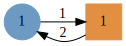

In [2]:
birth_petri = Open(PetriNet(1, 1=>(1,1)));
to_graphviz(birth_petri)

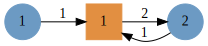

In [3]:
predation_petri = Open(PetriNet(2, (1,2)=>(2,2)));
to_graphviz(predation_petri)

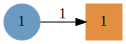

In [4]:
death_petri = Open(PetriNet(1, 1=>()));
to_graphviz(death_petri)

#### Step 2: Specify interaction between submodels using a relational syntax

To stitch independent open Petri nets together into a combined model, we need to specify an interaction pattern (composition syntax).
This is specified as an undirected wiring diagram (UWD) using the `@relation` macro from Catlab.jl, please see the documentation
there for more information.

The UWD produced here consists of 3 "boxes" and 2 "junctions". Boxes connect to junctions via wires based on the function-like syntax
in the macro. Wires that lead off the display are "outer ports" indicating how output may be collected from the combined system.

We use `oapply` to substitute the open Petri nets constructed earlier into each box of the UWD, where the feet of each open Petri net
are identified with the wires from each box to shared junctions. The result of `oapply` is, once again, a multicospan, where the legs
now give the map between outer ports of the composed model to places.

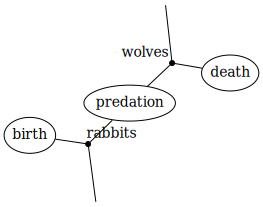

In [5]:
lotka_volterra = @relation (wolves, rabbits) begin
  birth(rabbits)
  predation(rabbits, wolves)
  death(wolves)
end
display_uwd(lotka_volterra)

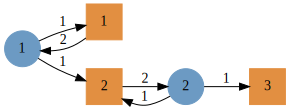

In [6]:
lv_dict = Dict(:birth=>birth_petri, :predation=>predation_petri, :death=>death_petri);
lotka_petri = apex(oapply(lotka_volterra, lv_dict))
to_graphviz(lotka_petri)

We can now define an initial state `u0`, reaction rate constants for each transition `p`, and use the method `vectorfield`
to create a function we can pass to a differential equation solver to simulate and plot a trajectory of our
composed Lotka-Volterra model.

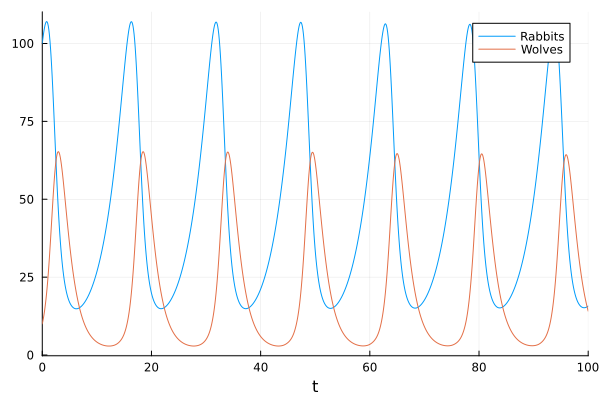

In [7]:
u0 = [100, 10];
p = [.3, .015, .7];
prob = ODEProblem(vectorfield(lotka_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5(),abstol=1e-8);
plot(sol, labels=["Rabbits" "Wolves"])

#### Step 3: Extend your model to handle more complex phenomena

By making a larger UWD to describe, we can describe a small food chain between little fish, big fish, and sharks.

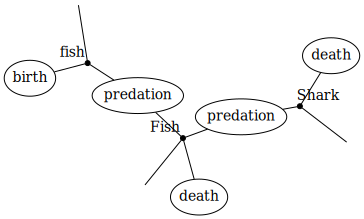

In [8]:
dual_lv = @relation (fish, Fish, Shark) begin
  birth(fish)
  predation(fish, Fish)
  death(Fish)
  predation(Fish, Shark)
  death(Shark)
end
display_uwd(dual_lv)

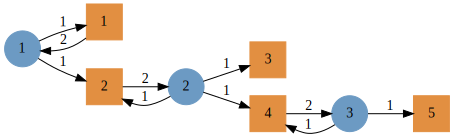

In [9]:
dual_lv_petri = apex(oapply(dual_lv, lv_dict))
to_graphviz(dual_lv_petri)

Generate a new solver, provide parameters, and analyze results

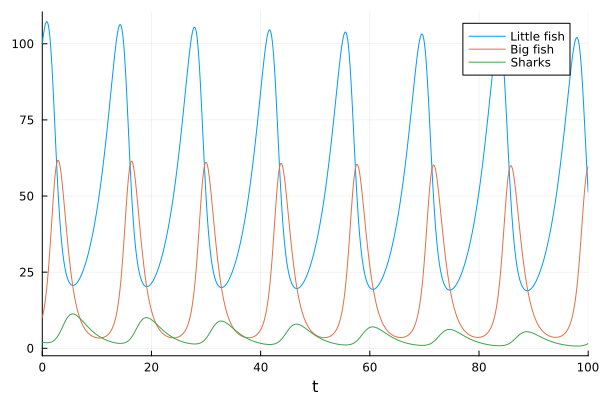

In [10]:
u0 = [100, 10, 2];
p = [.3, .015, .7, .017, .35];
prob = ODEProblem(vectorfield(dual_lv_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5(),abstol=1e-6);
plot(sol, label=["Little fish" "Big fish" "Sharks"])

However, at this point it is natural to be concerned about the scalability of needing to define
the UWD for larger models; is there a way to compose UWDs themselves to get a larger UWD?
As you may have guessed, the answer is yes. Let's see how.

Let's say we want to include another predator of rabbits into the model, hawks. Hawks
will behave like flying wolves in this setup, but they don't need to.

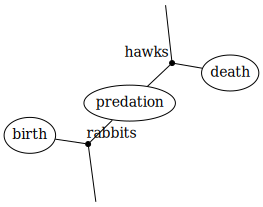

In [11]:
lotka_volterra_hawk = @relation (hawks, rabbits) begin
  birth(rabbits)
  predation(rabbits, hawks)
  death(hawks)
end
display_uwd(lotka_volterra_hawk)

We would like to "glue" the two UWDs describing terrestrial and aerial predation together
along the rabbits junction and birth box. We cannot simply take a disjoint union of the
two UWDs (coproduct) as then we would be modelling two disconnected systems. Instead we
need to perform a categorical operation called a "pushout", which is like a disjoint union
but where certain elements are glued together.

We specify this overlap between the two systems where we will glue them together below.

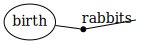

In [12]:
rabbit_uwd = @relation (rabbits,) begin
  birth(rabbits)
end
display_uwd(rabbit_uwd)

Next we need to define mappings from this overlap into each of the UWDs we want to glue together.
We use the `ACSetTransformation` method from Catlab for this, which defines a natural transformation
between two C-Sets. The result is a "span", where the apex is the overlap, and the acset transformations
are arrows from the apex into each of the original UWDs. We take the pushout of the span
to glue the UWDs together along the apex.

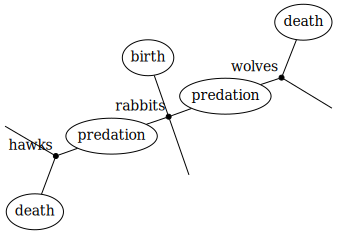

In [13]:
hawk_transform  = ACSetTransformation((Box=[1], Junction=[2], Port=[1], OuterPort=[2]), rabbit_uwd, lotka_volterra_hawk)
wolf_transform = ACSetTransformation((Box=[1], Junction=[2], Port=[1], OuterPort=[2]), rabbit_uwd, lotka_volterra)
lotka_volterra_composed = ob(pushout(hawk_transform, wolf_transform))

display_uwd(lotka_volterra_composed)

Now that we have the composition syntax for the combined terrestrial-aerial predation system, we
can substitute concrete mathematical models (open Petri nets) into each box as before to
produce a concrete model of the composed system.

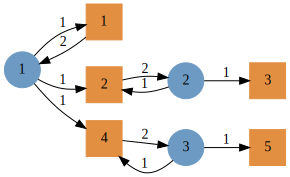

In [14]:
lotka_petri = apex(oapply(lotka_volterra_composed, lv_dict))
to_graphviz(lotka_petri)

We may now again interpret the model as a differential equation,
solve, and plot the solution.

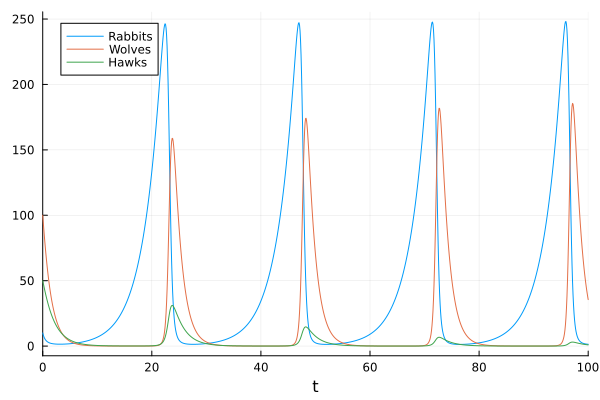

In [15]:
u0 = [10.0, 100.0, 50.0];
p = [.3, .015, .7, 0.01, 0.5];
prob = ODEProblem(vectorfield(lotka_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5());
plot(sol, label=["Rabbits" "Wolves" "Hawks"])